# Customer Segmentation Dataset

Objectives
1. sales per day
2. sales per product
3. sales per country
4. customer with highest purchase order
5. monthly sales turnout
6. product with highest purchase quantity

Determine
1. best month to push adverts
2. weakest day of the week for sales
3. product to emphasize more on purchase

In [149]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import autoreload
import missingno as msno
import os
import csv
import sys

from collections import defaultdict, Counter

sb.set_style('white')
sb.set()

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 1000)

%matplotlib inline

### Loading data from local machine

In [171]:
df = pd.read_excel("D:\Open Classroom\Datasets\Customer Segmentation Dataset\Online Retail.xlsx")
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


### Data Analysis and Cleaning

In [172]:
df.shape

(541909, 8)

In [173]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [174]:
df.describe().round()

,Quantity,UnitPrice,CustomerID
count,541909.0,541909.0,406829.0
mean,10.0,5.0,15288.0
std,218.0,97.0,1714.0
min,-80995.0,-11062.0,12346.0
25%,1.0,1.0,13953.0
50%,3.0,2.0,15152.0
75%,10.0,4.0,16791.0
max,80995.0,38970.0,18287.0


In [175]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [176]:
df['CustomerID'] = [i for i in df['CustomerID'].replace(np.nan, 0)]
df['CustomerID'].isnull().sum()

0

In [177]:
df.isnull().sum()

InvoiceNo         0
StockCode         0
Description    1454
Quantity          0
InvoiceDate       0
UnitPrice         0
CustomerID        0
Country           0
dtype: int64

In [178]:
df.dropna(axis = 'index', how = 'any', inplace = True)

In [179]:
df.isnull().sum()

InvoiceNo      0
StockCode      0
Description    0
Quantity       0
InvoiceDate    0
UnitPrice      0
CustomerID     0
Country        0
dtype: int64

In [180]:
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [181]:
df['Description'].value_counts()

WHITE HANGING HEART T-LIGHT HOLDER    2369
REGENCY CAKESTAND 3 TIER              2200
JUMBO BAG RED RETROSPOT               2159
PARTY BUNTING                         1727
LUNCH BAG RED RETROSPOT               1638
                                      ... 
SET 10 CARDS TRIANGLE ICONS  17220       1
GREEN/BLUE CERAMIC CANDLE HOLDER         1
CAKESTAND, 3 TIER, LOVEHEART             1
SET 10 CARDS 3 WISE MEN 17107            1
SET OF 6 EASTER RAINBOW CHICKS           1
Name: Description, Length: 4223, dtype: int64

#### Create a sales series to hold sales per item sold

In [182]:
df['Sales'] = df['UnitPrice'] * df['Quantity']
df.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,22.00


#### Sales per day

In [183]:
df['Weekday'] = df['InvoiceDate'].dt.day_name()
df.sample(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Weekday
337413,566446,22530,MAGIC DRAWING SLATE DOLLY GIRL,1,2011-09-12 15:40:00,0.83,0.0,United Kingdom,0.83,Monday
103225,545057,22148,EASTER CRAFT 4 CHICKS,12,2011-02-27 12:49:00,1.95,13630.0,United Kingdom,23.40,Sunday
5446,536862,84970s,HANGING HEART ZINC T-LIGHT HOLDER,5,2010-12-03 11:13:00,2.13,0.0,United Kingdom,10.65,Friday


Text(0.5, 1.0, 'Sales per day')

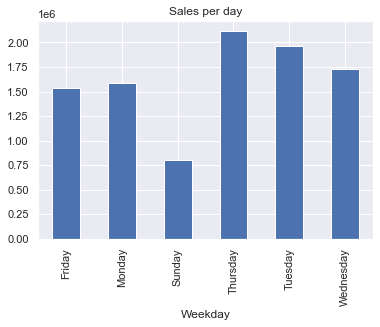

In [184]:
sales_per_day = df.groupby('Weekday')
day_sales = sales_per_day['Sales'].sum().plot(kind = 'bar')
plt.title('Sales per day')

#### Sales per month

##### create a months column to store monthly series

In [185]:
df['Month'] = df['InvoiceDate'].dt.month_name()
df.sample(4)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Weekday,Month
155594,550000,22672,FRENCH BATHROOM SIGN BLUE METAL,12,2011-04-14 09:18:00,1.65,17058.0,United Kingdom,19.80,Thursday,April
477220,577052,23358,HOT STUFF HOT WATER BOTTLE,1,2011-11-17 14:08:00,3.75,17397.0,United Kingdom,3.75,Thursday,November
485375,577598,23368,SET 12 COLOUR PENCILS DOLLY GIRL,16,2011-11-21 08:19:00,0.65,13430.0,United Kingdom,10.40,Monday,November
214935,555638,23173,REGENCY TEAPOT ROSES,2,2011-06-06 12:51:00,9.95,15150.0,United Kingdom,19.90,Monday,June


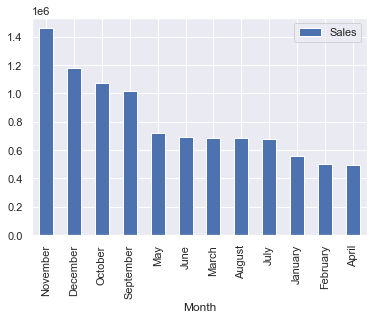

In [186]:
sales_per_month = df.groupby('Month').sum()
sales_per_month['Sales'].sort_values(ascending = False).to_frame().plot(kind = 'bar')

#### Sales per year

In [187]:
df['Year'] = df['InvoiceDate'].dt.year
df.head(2)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales,Weekday,Month,Year
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,15.30,Wednesday,December,2010
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,20.34,Wednesday,December,2010


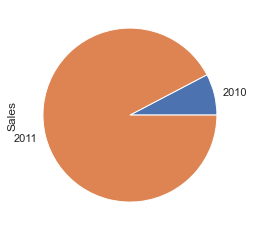

In [188]:
sales_per_year = df.groupby('Year')
sales_per_year['Sales'].sum().plot(kind = 'pie')

#### Customer with highest purchase

In [193]:
sales_per_customer = df.groupby('CustomerID')
sales_per_customer['Sales'].sum().sort_values(ascending = False).to_frame().head(6)

,Sales
CustomerID,
0.0,1447682.12
14646.0,279489.02
18102.0,256438.49
17450.0,187482.17
14911.0,132572.62
12415.0,123725.45


customer with ID 0 are outliers to the dataset since no information was fed earlier forcing to fill na with 0

#### Product with the highest purchase quantity

In [198]:
product_sale_quantity = df.groupby('Description')
product_sale_quantity['Quantity'].sum().sort_values(ascending = False).to_frame()

,Quantity
Description,
WORLD WAR 2 GLIDERS ASSTD DESIGNS,53847
JUMBO BAG RED RETROSPOT,47363
ASSORTED COLOUR BIRD ORNAMENT,36381
POPCORN HOLDER,36334
PACK OF 72 RETROSPOT CAKE CASES,36039
...,...
Damaged,-7540
Printing smudges/thrown away,-9058
check,-12030
